## SEP 740 Project Report - Group 9

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import time
import re
import nltk.corpus
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from keras import layers
from keras import initializers as initializers, regularizers, constraints
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.models import Model,Sequential
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.preprocessing.text import Tokenizer

from keras.optimizers import Adam
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
url = 'https://raw.githubusercontent.com/dashascience/-MBTI-Myers-Briggs-Personality-Type-Dataset/master/mbti_1.csv'
df = pd.read_csv(url)

In [ ]:
# normalize, remove stop words and url links.
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 
clean_text1=[]
for i in df.posts[0].split('|||'):
  i=i.lower()
  i = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", i)
  i_tokens = word_tokenize(i)
  filtered_i = [w for w in i_tokens if not w in stop_words]
  clean_text1.append(filtered_i)

In [ ]:
#lemmatization ensure that only words that mean similar things are consolidated into a single token
for j in clean_text1:
  for p in range(len(j)):
    j[p]=lemmatizer.lemmatize(j[p])


In [ ]:
# Clean methods for dataframe cleaning
def clean_data(str):
  clean_text1=[]
  for i in str.split('|||'):
    i=i.lower()
    i = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", i)
    i_tokens = word_tokenize(i)
    filtered_i = [w for w in i_tokens if not w in stop_words]
    clean_text1.append(filtered_i)
  return clean_text1

def lemmatized_data(strList):
  for j in strList:
    for p in range(len(j)):
      j[p]=lemmatizer.lemmatize(j[p])
  return strList

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
#MBTI related words
mbti = ["intj","intp","infj", "infp","istj","istp","isfj","isfp","entj","entp", "enfj", "enfp","estj", "estp","esfj","esfp","si","ni","ti","fi","se",
        "ne","te","fe","nt","nf","le","mbti","sp","sj","sf","st","in","is","en","es"]
data_length=[]
lemmatizer=WordNetLemmatizer()
clean_text1=[]
for i in range(0,len(df.posts)):
  doc = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", df.posts[i])
  doc = doc.lower()
  doc = doc.split()
  #Remove MBTI related words and lemmatize the rest words
  for w in doc:
    if w in mbti:
      doc.remove(w)
    elif not w in set(stopwords):
        lemmatizer.lemmatize(w) 

      
  doc = ' '.join(doc)
  clean_text1.append(doc)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
types = np.unique(df.type.values)

def get_type_index(string):
    return list(types).index(string)

df['type_index'] = df['type'].apply(get_type_index)
# Find the original posts column
n = df.columns[1]
# Drop that column
df.drop(n, axis = 1, inplace = True)
# Put cleaned posts in place
df[n] = clean_text1

In [ ]:
df

,type,type_index,posts
0,INFJ,8,and moments sportscenter not top ten plays pra...
1,ENTP,3,im finding the lack of me these posts very ala...
2,INTP,11,good one course to which i say i know thats my...
3,INTJ,10,dear i enjoyed our conversation the other day ...
4,ENTJ,2,youre firedthats another silly misconception t...
...,...,...,...
8670,ISFP,13,just because i always think of cats as doms fo...
8671,ENFP,1,soif this thread already exists someplace else...
8672,INTP,11,so many questions when i do these things i wou...
8673,INFP,9,i am very conflicted right now when it comes t...


In [ ]:
#Shows posts by group, we can see that the distribution is unbalanced
#ESTJ has the lowest number of posts which is 39
print(df.groupby(['type']).count().mean())
print(df.groupby(['type']).count())

type_index    542.1875
posts         542.1875
dtype: float64
      type_index  posts
type                   
ENFJ         190    190
ENFP         675    675
ENTJ         231    231
ENTP         685    685
ESFJ          42     42
ESFP          48     48
ESTJ          39     39
ESTP          89     89
INFJ        1470   1470
INFP        1832   1832
INTJ        1091   1091
INTP        1304   1304
ISFJ         166    166
ISFP         271    271
ISTJ         205    205
ISTP         337    337


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


#specify the amount of features
vocab_size = 10000

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df.posts)

import imblearn
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=39) # fit predictor and target variable


maxlen = 500
#Transform text into sequence and pad posts with size of 500
train_sequences = tokenizer.texts_to_sequences(df.posts.values)
train_padded = pad_sequences(train_sequences, maxlen = maxlen)
labels= tf.keras.utils.to_categorical(df.type_index.values, num_classes=16)
x_rus, y_rus = ros.fit_resample(train_padded, labels)
x_train,x_test,y_train,y_test=train_test_split(x_rus, y_rus, test_size=0.2, random_state=42)

#Transform text into sequence and pad posts with size of 500 for validation set

#show shape of different sets                            
print("Training set shape:",x_train.shape)
print("Testing set shape:",x_test.shape)


Training set shape: (23449, 500)
Testing set shape: (5863, 500)


##DNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, Flatten, Dropout, Conv1D, GlobalMaxPooling1D
#Build a regular cnn model and run on embedded text for 20 epoches
def create_model_NN():
    model = Sequential()
    model.add(Embedding(vocab_size,64,input_length=len(train_padded[0])))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(16, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = tf.optimizers.Adam(), metrics=['accuracy'])
    return model
model = create_model_NN()
history = model.fit(x_train,y_train, epochs = 40, verbose = 1, validation_data = (x_test, y_test))
hist = pd.DataFrame(history.history)
print(hist)

Epoch 1/40
733/733 [==============================] - 7s 5ms/step - loss: 1.4835 - accuracy: 0.4743 - val_loss: 0.6823 - val_accuracy: 0.7205
Epoch 2/40
733/733 [==============================] - 4s 5ms/step - loss: 0.6302 - accuracy: 0.7564 - val_loss: 0.4829 - val_accuracy: 0.8190
Epoch 3/40
733/733 [==============================] - 4s 5ms/step - loss: 0.4020 - accuracy: 0.8569 - val_loss: 0.4194 - val_accuracy: 0.8494
Epoch 4/40
733/733 [==============================] - 3s 5ms/step - loss: 0.2666 - accuracy: 0.9162 - val_loss: 0.4408 - val_accuracy: 0.8622
Epoch 5/40
733/733 [==============================] - 4s 5ms/step - loss: 0.1894 - accuracy: 0.9437 - val_loss: 0.4419 - val_accuracy: 0.8699
Epoch 6/40
733/733 [==============================] - 4s 5ms/step - loss: 0.1387 - accuracy: 0.9604 - val_loss: 0.5259 - val_accuracy: 0.8733
Epoch 7/40
733/733 [==============================] - 4s 5ms/step - loss: 0.1174 - accuracy: 0.9690 - val_loss: 0.5521 - val_accuracy: 0.8745
Epoch 

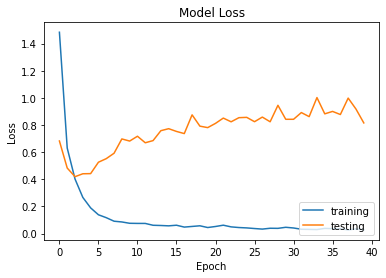

In [ ]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='testing')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend(loc='lower right')
plt.show()

##CNN

In [ ]:
from tensorflow.keras.layers import MaxPooling1D
def create_model_CNN():
    model = Sequential()
    model.add(Embedding(vocab_size,64,input_length=len(train_padded[0])))

    model.add(Conv1D(64,5,activation = "relu"))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D())

    model.add(Conv1D(64,5,activation = "relu"))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(16, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = tf.optimizers.Adam(), metrics=['accuracy'])
    return model

In [ ]:
model = create_model_CNN()
history = model.fit(x_train,y_train, epochs = 40, verbose = 1, validation_data = (x_test, y_test))
hist = pd.DataFrame(history.history)
print(hist)

Epoch 1/40
733/733 [==============================] - 12s 7ms/step - loss: 1.7610 - accuracy: 0.4314 - val_loss: 0.7509 - val_accuracy: 0.7525
Epoch 2/40
733/733 [==============================] - 5s 6ms/step - loss: 0.6918 - accuracy: 0.7549 - val_loss: 0.4910 - val_accuracy: 0.8327
Epoch 3/40
733/733 [==============================] - 5s 6ms/step - loss: 0.4353 - accuracy: 0.8397 - val_loss: 0.4326 - val_accuracy: 0.8504
Epoch 4/40
733/733 [==============================] - 5s 6ms/step - loss: 0.3338 - accuracy: 0.8765 - val_loss: 0.4494 - val_accuracy: 0.8595
Epoch 5/40
733/733 [==============================] - 5s 7ms/step - loss: 0.2741 - accuracy: 0.8996 - val_loss: 0.4672 - val_accuracy: 0.8634
Epoch 6/40
733/733 [==============================] - 5s 6ms/step - loss: 0.2411 - accuracy: 0.9123 - val_loss: 0.4908 - val_accuracy: 0.8663
Epoch 7/40
733/733 [==============================] - 5s 6ms/step - loss: 0.2028 - accuracy: 0.9264 - val_loss: 0.4936 - val_accuracy: 0.8700
Epoch

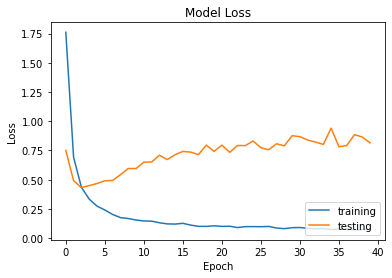

In [ ]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='testing')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend(loc='lower right')
plt.show()

##LSTMs

In [ ]:
#Build a RNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, Flatten, Dropout, Conv1D, GlobalMaxPooling1D
def create_model():
    model = Sequential()
    #apply embedding
    model.add(Embedding(vocab_size,80,input_length=maxlen))
    
    model.add(Bidirectional(LSTM(230)))

    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    
    model.add(Dense(16, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = tf.optimizers.Adam(), metrics=['accuracy'])
    return model

In [ ]:
model = create_model()
history = model.fit(x_train,y_train, epochs = 60, verbose = 1, validation_data = (x_test, y_test))
hist = pd.DataFrame(history.history)

Epoch 1/60
733/733 [==============================] - 47s 59ms/step - loss: 2.5709 - accuracy: 0.1287 - val_loss: 2.1050 - val_accuracy: 0.2627
Epoch 2/60
733/733 [==============================] - 42s 57ms/step - loss: 1.7424 - accuracy: 0.3453 - val_loss: 1.3993 - val_accuracy: 0.4573
Epoch 3/60
733/733 [==============================] - 43s 58ms/step - loss: 1.3411 - accuracy: 0.4589 - val_loss: 1.3813 - val_accuracy: 0.4551
Epoch 4/60
733/733 [==============================] - 43s 59ms/step - loss: 1.1350 - accuracy: 0.5250 - val_loss: 1.0827 - val_accuracy: 0.5854
Epoch 5/60
733/733 [==============================] - 43s 59ms/step - loss: 1.0006 - accuracy: 0.5749 - val_loss: 0.9995 - val_accuracy: 0.6338
Epoch 6/60
733/733 [==============================] - 42s 58ms/step - loss: 0.8769 - accuracy: 0.6284 - val_loss: 0.9314 - val_accuracy: 0.6903
Epoch 7/60
733/733 [==============================] - 42s 58ms/step - loss: 0.7905 - accuracy: 0.6606 - val_loss: 0.9359 - val_accuracy:

In [ ]:
print(hist)

        loss  accuracy  val_loss  val_accuracy
0   2.570888  0.128662  2.105042      0.262664
1   1.742422  0.345345  1.399342      0.457274
2   1.341090  0.458868  1.381315      0.455057
3   1.135030  0.525012  1.082728      0.585366
4   1.000567  0.574950  0.999494      0.633805
5   0.876912  0.628385  0.931444      0.690261
6   0.790516  0.660583  0.935891      0.696401
7   0.709935  0.691714  0.990790      0.669452
8   0.657064  0.714188  0.948216      0.727955
9   0.617666  0.731630  0.894043      0.726590
10  0.592198  0.747708  0.898698      0.741600
11  0.556125  0.763572  0.851421      0.737677
12  0.524389  0.784980  0.859125      0.767525
13  0.486796  0.798669  0.922195      0.764114
14  0.442911  0.821954  0.946918      0.783899
15  0.433742  0.827370  0.919034      0.801979
16  0.399357  0.844258  0.938973      0.791404
17  0.363714  0.856966  0.949513      0.797032
18  0.359667  0.866647  0.951254      0.777929
19  0.323767  0.878588  1.053440      0.778612
20  0.318369 

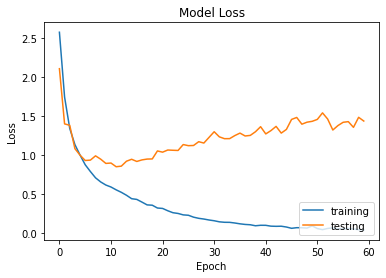

In [ ]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='testing')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend(loc='lower right')
plt.show()